# Project 7: The Time Series Analysis

In this project, you will create a short-term temperature forecast.

- Get and clean temperature data from www.ecad.eu **I got the data from BERKELEY EARTH**             http://berkeleyearth.lbl.gov/stations/155194

- Build a baseline model modelling trend and seasonality

- Plot and inspect the different components of a time series

- Model time dependence of the remainder using an AR model

- Compare the statistical output of different AR models

- Test the remainder for stationarity

- upload your code to GitHub

All DONE

**Note: when the place for a figure is white that is due to the fact that I produced it with plotly, so you might not see it after I pushed my notebook to github

In [1]:
#import all necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm #Cross-sectional models and methods
import statsmodels.tsa.api as tsa #Time-series models and methods
import statsmodels.formula.api as smf #specifying models using formula strings and DataFrames
from statsmodels.api import OLS, add_constant, qqplot
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.tsatools import lagmat
import plotly.express as px

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

**Get and clean temperature data from BERLIN-TEMPELHOF** time range: 1700-2011

- import the data and check data types and missing values

In [2]:
#importing the data and preparing the dataframe
df = pd.read_csv('data.csv')
df=df.drop('Unnamed: 0', axis=1)

- change column names and remove the missing values

In [3]:
#change column names
df.columns=['year','month', 'temperature(raw)', 'anomaly(raw)', 'failed', 'breaks', 'temperature(adj)', 'anomaly(adj)', 'temperature(e)','anomaly(e)']

In [4]:
#what is the shape of the data and the percentage of the missing values
print(f"""The data is with {df.shape} observations, and the percentage of missing vlaues\n{round(df.isna().sum()* 100 / len(df),2)}""")

The data is with (3522, 10) observations, and the percentage of missing vlaues
year                 0.00
month                0.00
temperature(raw)     1.36
anomaly(raw)         1.36
failed               1.36
breaks               1.36
temperature(adj)     1.48
anomaly(adj)         1.48
temperature(e)      10.08
anomaly(e)          10.08
dtype: float64


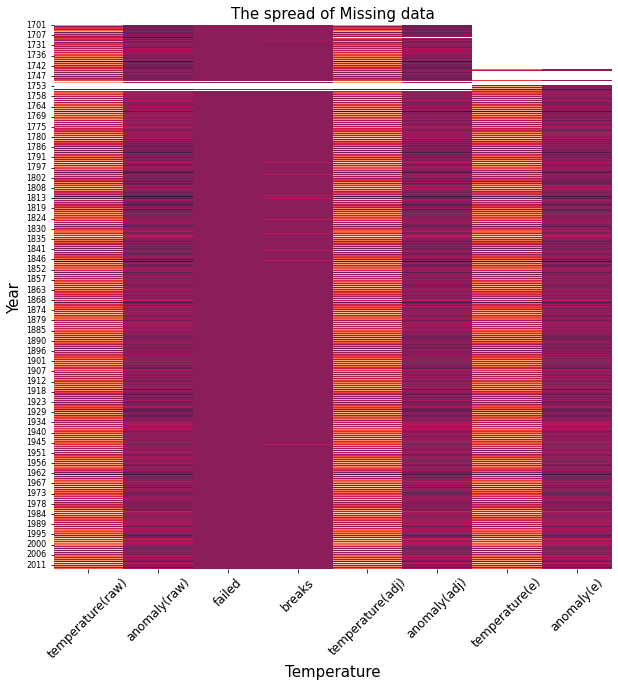

In [5]:
#plot the distribution of the missing data
df_year=df.set_index('year')
df_year=df_year.drop('month', axis=1)
#import missingno as msno
plt.subplots(figsize=(10,10))
sns.heatmap(df_year,cbar=False)
plt.title('The spread of Missing data', fontsize=15)
plt.xlabel('Temperature',fontsize=15);plt.ylabel('Year',fontsize=15)
plt.xticks(rotation=45,fontsize=12)
plt.yticks(fontsize=8);

In [6]:
#drop nas and see how it is gonna look
df.dropna(inplace=True)

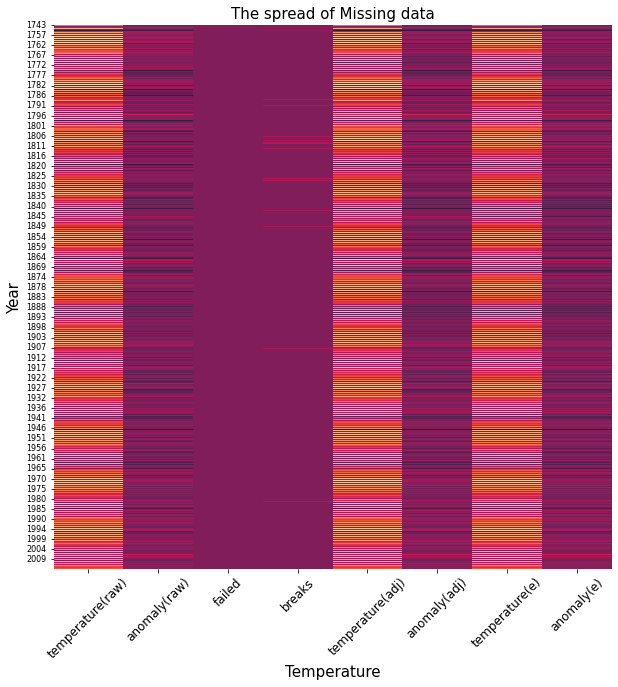

In [7]:
#plot the distribution of the missing values
df_year=df.set_index('year')
df_year=df_year.drop('month', axis=1)
#import missingno as msno
plt.subplots(figsize=(10,10))
sns.heatmap(df_year,cbar=False)
plt.title('The spread of Missing data', fontsize=15)
plt.xlabel('Temperature',fontsize=15);plt.ylabel('Year',fontsize=15)
plt.xticks(rotation=45,fontsize=12)
plt.yticks(fontsize=8);

In [8]:
print(f"""we have {round(len(df['year'])/12/100,2)} centuries, and {round(len(df['year'])/12,1)} years and {round(len(df['month']))} months""")

we have 2.61 centuries, and 260.6 years and 3127 months


In [9]:
df_table=df.filter(['year','month'])
df_count=df_table.pivot_table(index=['year'], columns=['month'], aggfunc=len)
df_count

month   1    2    3    4    5    6    7    8    9    10   11   12
year                                                             
1743   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  NaN
1744   NaN  NaN  NaN  1.0  1.0  1.0  1.0  NaN  1.0  1.0  1.0  1.0
1745   1.0  1.0  1.0  1.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
1750   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  NaN  1.0
1751   1.0  1.0  1.0  1.0  NaN  1.0  NaN  1.0  1.0  NaN  NaN  NaN
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
2009   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
2010   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
2011   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
2012   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
2013   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  NaN  NaN

[264 rows x 12 columns]

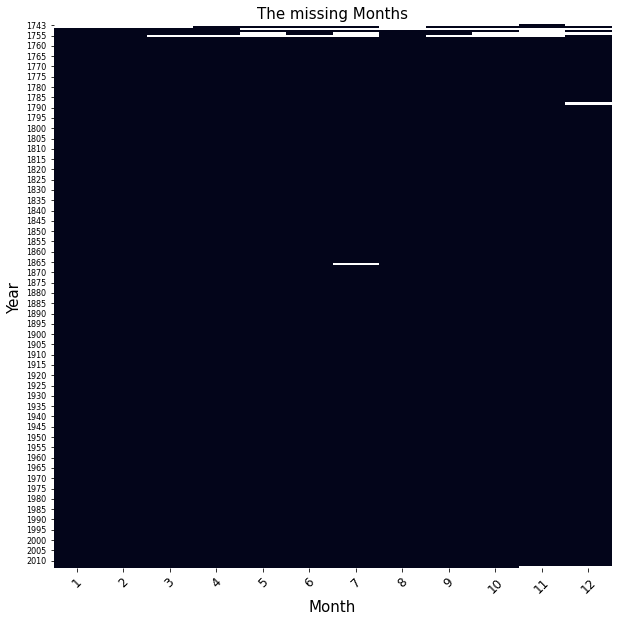

In [10]:
plt.subplots(figsize=(10,10))
sns.heatmap(df_count,cbar=False)
plt.title('The missing Months', fontsize=15)
plt.xlabel('Month',fontsize=15);plt.ylabel('Year',fontsize=15)
plt.xticks(rotation=45,fontsize=12)
plt.yticks(fontsize=8);

**years before 1750 do not give tem for 12 months so they have to be removed**

In [11]:
#make a boolean series for years that do not have 12 months.
check=df.groupby('year')['month'].count()==12

In [12]:
#see the check
check

year
1743    False
1744    False
1745    False
1750    False
1751    False
        ...  
2009     True
2010     True
2011     True
2012     True
2013    False
Name: month, Length: 264, dtype: bool

In [13]:
#collect the years that do not have 12 month
list_years=[]
for index, value in check.items():
    if value == False:
        list_years.append(index)
        print(index)

1743
1744
1745
1750
1751
1755
1788
1866
2013


In [14]:
#the year with less than 12 months
list_years

[1743, 1744, 1745, 1750, 1751, 1755, 1788, 1866, 2013]

In [15]:
df_final=df.set_index('year')
df_final=df_final.drop([1743, 1744, 1745, 1750, 1751, 1755, 1788, 1866, 2013], axis=0)

In [16]:
#just a final check:
check2=df_final.groupby('year')['month'].count()==12
for index, value in check2.items():
    if value == False:
        print(index)
    else:
        print('clean')

clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clea

In [17]:
#take the years only between 1866 and 2013
df_final=df_final.query('year >1866 and year < 2013')

In [18]:
#write the clean data to the directory
df_final.to_csv('Berkeley')

# Plotting using Plotly

In [19]:
df_plot=df_final.reset_index()

In [20]:
#create two dataframes one for tem and one for anomalies
df_plot=df_plot.filter(['year','temperature(raw)', 'temperature(adj)', 'temperature(e)','anomaly(raw)', 'anomaly(adj)', 'anomaly(e)'])

In [21]:
#plot the temperature
#import plotly.express as px
#tem=df_plot_tem.rolling(12)
#fig = px.line(tem.mean(), x="year", y=tem.mean().columns, hover_data={"year"},title='Temperature in Berlin Tempelhof 1867-2012')
#fig.show()

In [22]:
#plot the nomaly
#anom=df_plot_anom.rolling(12)
#fig = px.line(anom.mean(), x="year", y=anom.mean().columns, hover_data={"year"},title='Temperature in Berlin Tempelhof 1867-2012')
#fig.show()

In [40]:
#compined together the anomaly and temperature
r=df_plot.rolling(12)
fig = px.line(r.mean(), x="year", y=r.mean().columns, hover_data={"year"},title='Temperature in Berlin Tempelhof 1867-2012')
#fig.add_hline(y=df_plot['temperature(e)'].mean(),line_width=1, line_dash="dash", line_color="red",
             #annotation_text="mean value of Temperature(e)", annotation_position="bottom right",
              #annotation_font_size=15,
              #annotation_font_color="red")
fig.add_hline(y=df_plot['anomaly(e)'].mean(),line_width=1, line_dash="dash")
fig.update_xaxes(rangeslider_visible=True)
fig.show()

**Build a baseline model modelling trend and seasonality** 

**Using Statsmodel** 

**Set the index into Datetime with "M" frequency**

In [24]:
#import the clean data with year as an index (timedate object)
Temp=pd.read_csv('Berkeley')

In [25]:
#y=pd.date_range(start='1867-01-0', end='2012-12-0',periods=145, freq='M')
y=pd.date_range(start='1/1/1867', end='12/12/2012', freq='M')

In [26]:
y=pd.Series(y, name='date')

In [27]:
Temp=Temp.merge(y,left_index=True,right_index=True)
type(Temp)

pandas.core.frame.DataFrame

In [28]:
Temp2= Temp[['date','temperature(raw)']]

In [29]:
Temp2.set_index('date',inplace=True)

**Decomposition with Statsmodel.tsa.seasonal**

another way with statsmodel:https://www.statsmodels.org/devel/generated/statsmodels.tsa.seasonal.STL.html

In [30]:
from statsmodels.tsa.seasonal import seasonal_decompose
sd = seasonal_decompose(Temp2['temperature(raw)'], model='additive')

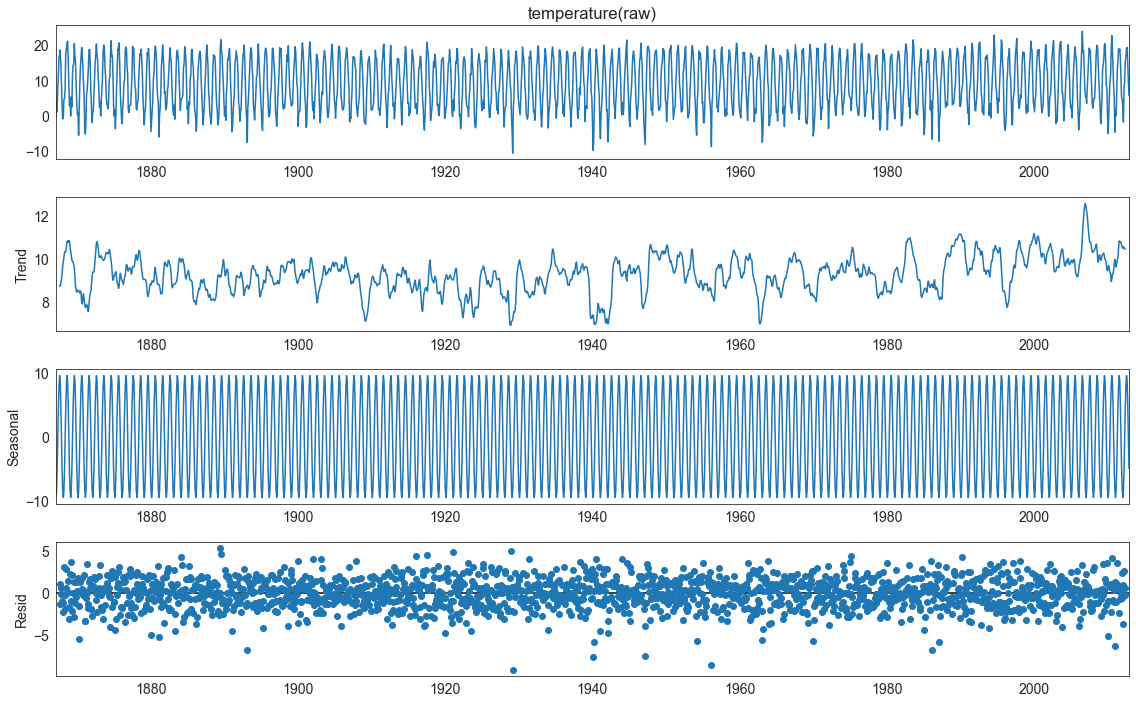

In [31]:
sns.set_style("white")
# Default figure size
sns.mpl.rc("figure", figsize=(16, 10))
sns.mpl.rc("font", size=14)
sd.plot()
None

In [32]:
#create an empty dataframe
outcome = pd.DataFrame(columns = ['observed', 'trend', 'seasonal','residuals'])

In [33]:
#make the dataframe out of the outcomes
outcome['observed']=sd.observed
outcome['trend']=sd.trend
outcome['seasonal']=sd.seasonal
outcome['residuals']=sd.resid

In [34]:
outcome.sample(3)

observed     trend  seasonal  residuals
date                                               
1884-09-30    16.100  9.075000  5.298843   1.726157
1929-11-30     5.300  9.670833 -4.837718   0.466885
2004-06-30    16.337  9.813083  7.861220  -1.337303

In [35]:
r=outcome.rolling(12) #alternative for groupby specific for time series

In [36]:
#PLOT THE TREND AND TEMPERATURE using the mean value for each year
fig = px.line(outcome, y='trend', title='Trend across years')
fig.update_xaxes(rangeslider_visible=True)
fig.add_hline(y=outcome['trend'].mean(),line_width=0.5, line_dash="dash", line_color="red")
fig.show()

In [37]:
#plot the residuals
fig = px.line(outcome, y='residuals', title='Residuals of AR')
fig.add_hline(y=0.0,line_width=0.5, line_dash="dash", line_color="red")
fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [38]:
#plot the whole outcome of AR
#r=outcome.rolling(12)
fig = px.line(outcome, y=outcome.columns, title='AR Analysis')
fig.update_xaxes(rangeslider_visible=True)
fig.add_hline(y=0.0,line_width=1.5, line_dash="dash", line_color="red")
fig.show()

In [43]:
#PLOT THE TREND AND TEMPERATURE using the mean value for each year
#r=outcome.rolling(12) #alternative for groupby specific for time series
#r.mean()['observed'].plot(figsize=(20,6))
#r.mean()['trend'].plot(figsize=(20,6))
#plt.title('Temperature and Trend across years', fontsize=15)
#plt.xlabel('Year',fontsize=15);plt.ylabel('Tm',fontsize=15)
#plt.xticks(rotation=0,fontsize=15)
#plt.yticks(fontsize=12);

# Autoregressive Model

**Check up whether the data is STATIONARY**

1.**The Augmented Dickey-Fuller test**
https://www.statsmodels.org/devel/examples/notebooks/generated/stationarity_detrending_adf_kpss.html

The ADF test:
- Null Hypothesis: The series has a unit root, in other words, the series is non-stationary
- Alternate Hypothesis: The series has no unit root, in other words, the series is stationary

In [44]:
#make a one variable for residual and one variable for observed
resid=outcome['residuals'].dropna()
obs=outcome['observed'].dropna()

In [45]:
#using statsmodel
from statsmodels.tsa.stattools import adfuller

#------ DESCLAIMER: i did not write this function, just took it from statsmodel page provided above--------

def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(round(dfoutput,3))
    
adf_test(resid)

Results of Dickey-Fuller Test:
Test Statistic                  -16.109
p-value                           0.000
#Lags Used                       25.000
Number of Observations Used    1713.000
Critical Value (1%)              -3.434
Critical Value (5%)              -2.863
Critical Value (10%)             -2.568
dtype: float64


2.**KPSS test**

**The null and alternate hypothesis for the KPSS test are opposite that of the ADF test.**

- Null Hypothesis: The process is trend stationary.
- Alternate Hypothesis: The series has a unit root (series is not stationary).

In [46]:
from statsmodels.tsa.stattools import kpss

#------ DESCLAIMER: i did not write this function, just took it from statsmodel page--------
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(round(kpss_output,3))
kpss_test(resid)                      #d=0 for ARIMA cause we have stationary

Results of KPSS Test:
Test Statistic             0.040
p-value                    0.100
Lags Used                127.000
Critical Value (10%)       0.347
Critical Value (5%)        0.463
Critical Value (2.5%)      0.574
Critical Value (1%)        0.739
dtype: float64


**Determine how many lags the regression requires**

partial Autocorrelation: https://www.statsmodels.org/devel/generated/statsmodels.tsa.stattools.pacf.html

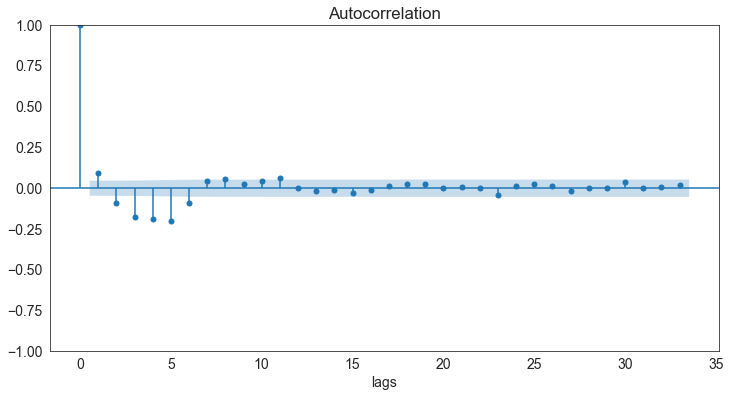

In [48]:
from statsmodels.graphics.tsaplots import plot_acf
sns.mpl.rc("figure", figsize=(12,6))
sns.mpl.rc("font", size=14)
plot_acf(resid)
plt.xlabel('lags'); #the number of q is 7 for ARIMA

In [53]:
#how many lags we can add to the model
lag_number=ar_select_order(resid, maxlag = 24)
print(f"""The number of lags (p for ARIMA) that should be included is: {len(lag_number.ar_lags)}""")

The number of lags (p for ARIMA) that should be included is: 23


In [54]:
print(f"""The number of q for ARIMA is 7""")

The number of q for ARIMA is 7


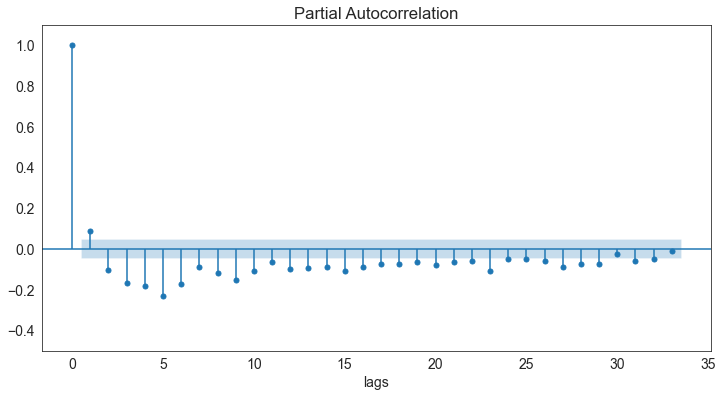

In [55]:
#check this with Partial Autocorrelation
from statsmodels.graphics.tsaplots import plot_pacf
sns.mpl.rc("figure", figsize=(12,6))
sns.mpl.rc("font", size=14)
plot_pacf(resid)
plt.xlabel('lags')
plt.ylim(-0.5,1.1);

https://www.statsmodels.org/devel/generated/statsmodels.tsa.ar_model.AutoReg.html

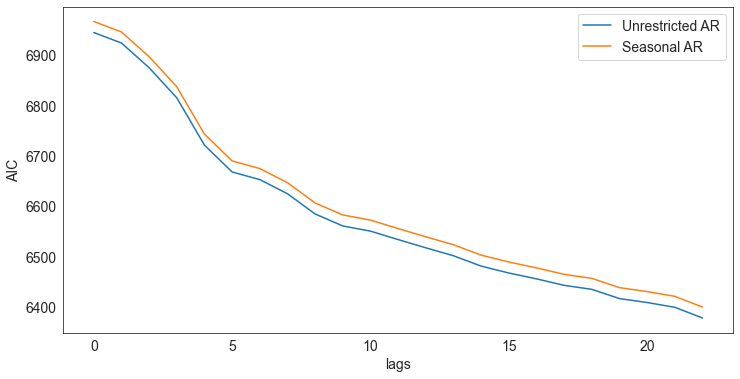

In [56]:
#make a for loop to plot all AIC for the lags
#unrestricted Seasonal AR model

lags=lag_number.ar_lags
AIC=[]
for i in lags:
    result=AutoReg(resid, i).fit()
    AIC.append(result.aic)
plt.plot(AIC,label='Unrestricted AR')
plt.legend()
plt.xlabel('lags')
plt.ylabel('AIC')

#INCLUDE both the seasonal dummies and lags in AR structure 
lags=lag_number.ar_lags
AIC=[]
for i in lags:
    result=AutoReg(resid, i,seasonal=True, period=12).fit() #the perfect one was with periods=4
    AIC.append(result.aic)
plt.plot(AIC,label='Seasonal AR')
plt.legend()
plt.xlabel('lags')
plt.ylabel('AIC');

**generate the lags needed for the cross-validation using statsmodel**
https://www.statsmodels.org/devel/generated/statsmodels.tsa.tsatools.lagmat2ds.html

In [57]:
#generate a dataframe with residuals and all lags
lags=sm.tsa.tsatools.lagmat2ds(resid, 23, maxlagex=None, dropex=0, trim='forward', use_pandas=True)

**generate dummy variables using statsmodel tsa**
https://www.statsmodels.org/devel/generated/statsmodels.tsa.deterministic.Seasonality.html

In [58]:
from statsmodels.datasets import sunspots
from statsmodels.tsa.deterministic import Seasonality
#generate the seasonal dummies from the statsmodel 
seas_gen = Seasonality(12)
dummies=seas_gen.in_sample(resid.index) #for the index and not the variable

**Construct a DataFrame for the cross-validation**

In [59]:
#merge them based on their indexes
Temp3=lags.merge(dummies,left_index=True, right_index=True)
Temp3=Temp3.merge(obs, left_index=True, right_index=True)

In [139]:
Temp3

residuals  residuals.L.1  residuals.L.2  residuals.L.3  \
date                                                                 
1867-07-31  -1.323950       0.000000       0.000000       0.000000   
1867-08-31   1.124747      -1.323950       0.000000       0.000000   
1867-09-30   0.705324       1.124747      -1.323950       0.000000   
1867-10-31  -0.041520       0.705324       1.124747      -1.323950   
1867-11-30  -0.858115      -0.041520       0.705324       1.124747   
...               ...            ...            ...            ...   
2012-01-31   1.043399       2.475113      -0.605949      -0.088895   
2012-02-29  -3.718359       1.043399       2.475113      -0.605949   
2012-03-31   2.697640      -3.718359       1.043399       2.475113   
2012-04-30  -0.148328       2.697640      -3.718359       1.043399   
2012-05-31   0.604477      -0.148328       2.697640      -3.718359   

            residuals.L.4  residuals.L.5  residuals.L.6  residuals.L.7  \
date                                                                     
1867-07-31       0.000000       0.000000       0.000000       0.000000   
1867-08-31       0.000000       0.000000       0.000000       0.000000   
1867-09-30       0.000000       0.000000       0.000000       0.000000   
1867-10-31       0.000000       0.000000       0.000000       0.000000   
1867-11-30      -1.323950       0.000000       0.000000       0.000000   
...                   ...            ...            ...            ...   
2012-01-31       0.387199      -0.663003      -2.343075       0.815905   
2012-02-29      -0.088895       0.387199      -0.663003      -2.343075   
2012-03-31      -0.605949      -0.088895       0.387199      -0.663003   
2012-04-30       2.475113      -0.605949      -0.088895       0.387199   
2012-05-31       1.043399       2.475113      -0.605949      -0.088895   

            residuals.L.8  residuals.L.9  ...  s(7,12)  s(8,12)  s(9,12)  \
date                                      ...                              
1867-07-31       0.000000       0.000000  ...      0.0      0.0      0.0   
1867-08-31       0.000000       0.000000  ...      0.0      0.0      0.0   
1867-09-30       0.000000       0.000000  ...      0.0      0.0      0.0   
1867-10-31       0.000000       0.000000  ...      0.0      0.0      0.0   
1867-11-30       0.000000       0.000000  ...      0.0      0.0      0.0   
...                   ...            ...  ...      ...      ...      ...   
2012-01-31       0.886269       3.593338  ...      1.0      0.0      0.0   
2012-02-29       0.815905       0.886269  ...      0.0      1.0      0.0   
2012-03-31      -2.343075       0.815905  ...      0.0      0.0      1.0   
2012-04-30      -0.663003      -2.343075  ...      0.0      0.0      0.0   
2012-05-31       0.387199      -0.663003  ...      0.0      0.0      0.0   

            s(10,12)  s(11,12)  s(12,12)  observed  predicted  \
date                                                            
1867-07-31       0.0       0.0       0.0    17.100  18.944714   
1867-08-31       0.0       0.0       0.0    18.800  18.438984   
1867-09-30       0.0       0.0       0.0    14.900  14.826943   
1867-10-31       0.0       0.0       0.0     9.200   9.540569   
1867-11-30       0.0       0.0       0.0     3.600   4.346981   
...              ...       ...       ...       ...        ...   
2012-01-31       0.0       0.0       0.0     2.161  -0.315951   
2012-02-29       0.0       0.0       0.0    -1.609  -0.108850   
2012-03-31       0.0       0.0       0.0     8.115   3.822045   
2012-04-30       1.0       0.0       0.0     9.792   8.603671   
2012-05-31       0.0       1.0       0.0    15.563  12.987443   

            ARIMA_predicted  AR_predicted  
date                                       
1867-07-31        -0.000021           NaN  
1867-08-31        -0.115886           NaN  
1867-09-30         0.240188           NaN  
1867-10-31         0.174703           NaN  
1867-11-30         0.008571           N

# Cross-validation

In [61]:
#I have a ready dataframe with lags and dummies and one series for the observed (temperature)
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression

In [62]:
#identify the feature matrix and the response
X = Temp3.drop(['observed', 'residuals'], axis=1) #features/independent variables
y = Temp3['observed'] #target/dependent variable

In [63]:
# initialize the splitting model
Ts = TimeSeriesSplit(n_splits=5) # a proper sequential split across the data -- each couple of years, months....

In [64]:
# fit the features and response 
time_series_split = Ts.split(X, y) #

In [65]:
m = LinearRegression()
#m.fit(X, y)#not important, we are using just the linear model but not the x and y

In [66]:
# Do the cross validation: Remember these are the 'test scores' in the training data.
score = cross_val_score(estimator=m, X=X, y=y,cv=time_series_split)
f"Mean cross-validation score: {score.mean():5.3f}"

'Mean cross-validation score: 0.937'

# Plot the predicted values against the true values

In [67]:
#using the whole dataset Temp3
X = Temp3.drop(['observed', 'residuals'], axis=1) #features/independent variables
y = Temp3['observed']

In [68]:
#create the linear regression model using statsmodel and make the fit
lm = sm.OLS(y, X)
model = lm.fit()

In [69]:
#print the coefficients and the R2 adjusted
#print("Parameters: ", model.params)
print("R2: ", model.rsquared)

R2:  0.9402863005196908


In [70]:
#plot some diagnostic
Temp3['predicted']=model.predict()

In [71]:
Temp4=Temp3.filter(['observed', 'predicted'])

<AxesSubplot:xlabel='date'>

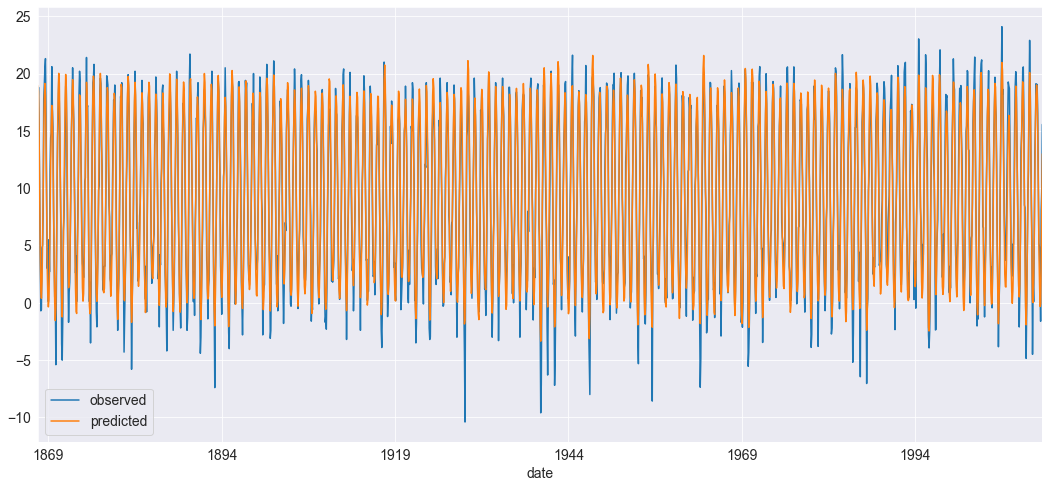

In [138]:
#plotting using pandas plot function
Temp4.plot()

In [72]:
#using plotly --- it may not be there after i push the notebook
fig = px.line(Temp4, y=Temp4.columns, title='observed and predicted')
fig.update_xaxes(rangeslider_visible=True)
fig.add_hline(y=0.0,line_width=0.5, line_dash="dash", line_color="black")
fig.show()

# Make future predictions

In [76]:
#plot the predicted future with confidence interval
from statsmodels.tsa.api import graphics
import pandas_datareader as pdr
sns.set_style("darkgrid")
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc("figure", figsize=(16, 4))
sns.mpl.rc("font", size=12)

In [103]:
#make the AR Analysis with lags and seasonal
AR=AutoReg(resid, 23, seasonal=True, period=4).fit()

In [122]:
Temp3['AR_predicted']=AR.predict()

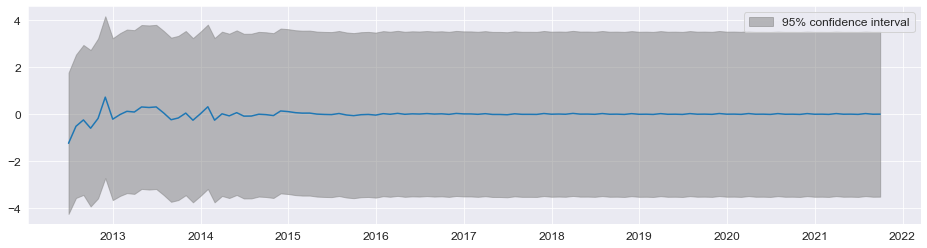

In [75]:
#plot prediction based on the Autoregressive model developed before
AR.plot_predict(1739,1850)
None

# ARIMA model

In [98]:
#build ARIMA model using previous knowledge about p, q, and d parameters 
from statsmodels.tsa.arima.model import ARIMA
ARIMA = ARIMA(resid, order=(23,0,7))
ARIMA_MODEL = model.fit()

In [107]:
#the akaike information criterion between AR and ARIMA
print("AR AIC score: ", round(AR.aic,2))
print("ARIMA AIC: ", round(ARIMA_MODEL.aic,2))

AR AIC score:  6383.5
ARIMA AIC:  6358.54


In [123]:
#add the predicted from ARIMA to the temp3 dataframe
Temp3['ARIMA_predicted']=ARIMA_MODEL.predict()

In [124]:
#Temp3.to_csv('with_ARIMA')

<AxesSubplot:xlabel='date'>

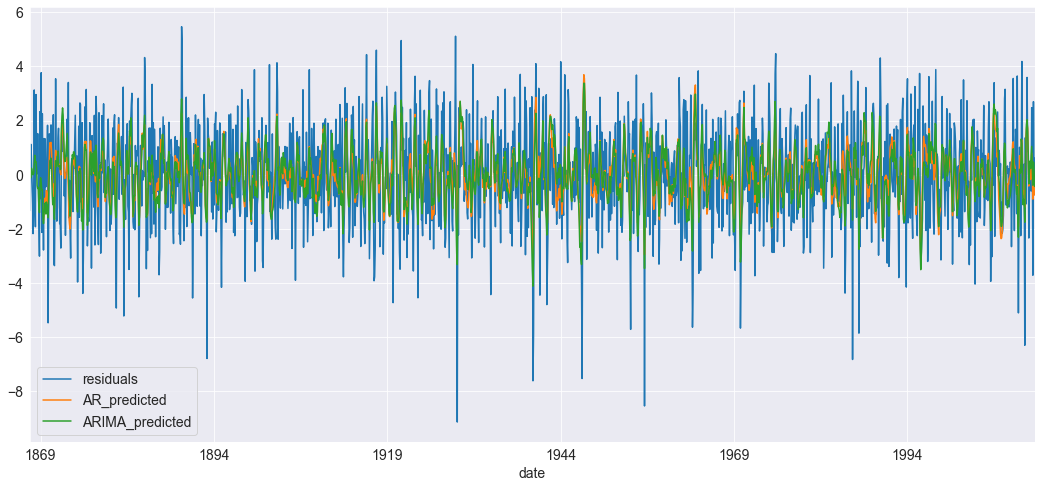

In [137]:
#plot the result from AR and ARIMA
sns.mpl.rc("figure", figsize=(18,8))
sns.mpl.rc("font", size=14)
Temp3[['residuals', 'AR_predicted', 'ARIMA_predicted']].plot()

In [125]:
#make a dataframe for plotly
Temp5=Temp3.filter(['residuals','AR_predicted', 'ARIMA_predicted'])

In [126]:
#plot using plotly .......
fig = px.line(Temp5, y=Temp5.columns, title='AR vs ARIMA')
fig.update_xaxes(rangeslider_visible=True)
fig.add_hline(y=0.0,line_width=0.5, line_dash="dash", line_color="black")
fig.show()

# Personal progress assessment:

- I learned how to deal with statsmodel
- I practiced new functions and methods in python like rolling() and resample() and asfreq() for time series
- I have used again the plotly libraries for plotting
- I revisited important statistical topics like Autoregression Analysis and ARIMA 
- I learned how to deal with time series problems like using splitting, testing for stationary and analysis

# Difficulties:

- almost none this week 03.31.2022